# 注視領域の可視化
- saliency mapとGrad-CAMを出してみる

In [1]:
import numpy as np

f = np.load('mnist.npz')
x_train = f['x_train']
y_train = f['y_train']
x_test = f['x_test']
y_test = f['y_test']

# 28 x 28ピクセルの画像を[0,1]に正規化
x_train = np.reshape(x_train, (60000, 28,28,1)) / 255.
x_test = np.reshape(x_test, (10000, 28,28,1)) / 255.

# one-hotベクトルに変換
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [2]:
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.models import Model

x = Input(shape=(28,28,1))

h = Conv2D(32, (3,3), padding='same')(x)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Conv2D(32, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Conv2D(32, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Conv2D(32, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Conv2D(32, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Conv2D(32, (3,3), padding='same')(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = GlobalAveragePooling2D()(h)

h = Dense(32)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Dense(32)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Dense(10)(h)
h = BatchNormalization()(h)
y = Activation('softmax')(h)

cnn = Model(inputs=x, outputs=y)

Using TensorFlow backend.


In [3]:
cnn.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc'],
)

In [4]:
from keras.callbacks import ModelCheckpoint

check_pointer = ModelCheckpoint(
    filepath='best_weights.h5',
    monitor='val_acc',
    verbose=0, 
    mode='max'
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 658s - loss: 0.4216 - acc: 0.9149 - val_loss: 0.5776 - val_acc: 0.8233
Epoch 2/20
54000/54000 [==============================] - 619s - loss: 0.1651 - acc: 0.9647 - val_loss: 0.5318 - val_acc: 0.8158
Epoch 3/20
54000/54000 [==============================] - 614s - loss: 0.1130 - acc: 0.9735 - val_loss: 0.4875 - val_acc: 0.8408
Epoch 4/20
54000/54000 [==============================] - 614s - loss: 0.0860 - acc: 0.9792 - val_loss: 0.3249 - val_acc: 0.8970
Epoch 5/20
54000/54000 [==============================] - 614s - loss: 0.0716 - acc: 0.9819 - val_loss: 0.0526 - val_acc: 0.9843
Epoch 6/20
54000/54000 [==============================] - 615s - loss: 0.0632 - acc: 0.9833 - val_loss: 0.1040 - val_acc: 0.9715
Epoch 7/20
54000/54000 [==============================] - 614s - loss: 0.0563 - acc: 0.9850 - val_loss: 0.1245 - val_acc: 0.9645
Epoch 8/20
54000/54000 [========================

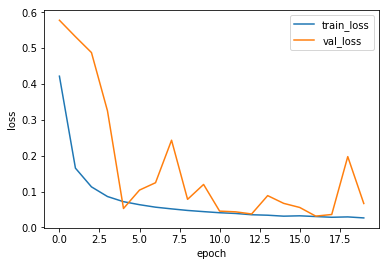

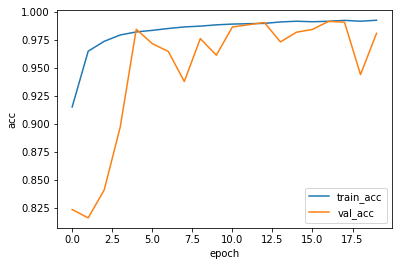

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

if True:
    hist = cnn.fit(
        x = x_train,
        y = y_train,
        epochs=20,
        validation_split=0.1,
        callbacks=[check_pointer],
    )
#    cnn.save_weights('weights.h5')

    plt.plot(hist.epoch, hist.history['loss'], label='train_loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    plt.plot(hist.epoch, hist.history['acc'], label='train_acc')
    plt.plot(hist.epoch, hist.history['val_acc'], label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
else:
    cnn.load_weights('best_weights.h5')

# Saliency Map
- [元論文 "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps"](https://arxiv.org/abs/1312.6034)
- 入力画像を$x_j$、CNNの出力を$y_i$としたとき、saliency map $S^i_{j}$は以下で定義される。
$$
S^i_j = ¥frac{¥partial y_i}{¥partial x_j}
$$

In [38]:
import keras.backend as K
import tensorflow as tf

def compile_saliency_function(model):
    '''
    dy/dxを計算する関数を返す。作成する関数の引数は2つ（リストにして渡す）。
   　　 引数１：入力画像。
   　  引数２：訓練フェーズ。0を入れればOK。
    ＊ BatchNormalizationは訓練時とテスト時で挙動が異なる。
    そのため、BatchNormalizationを含むモデルから関数を作る場合は、
    明示的に訓練フェーズ（１が訓練、０がテスト）を与える必要がある。
    '''
    outp = model.layers[-1].output # y_i
    max_outp = K.max(outp,-1)
    inp = model.layers[0].input # x_j
    saliency = K.gradients(max_outp, inp) # d y_i/ d x_j
#    outp_split = [tf.slice(outp,[0,0],[-1,1]) for i in range(K.int_shape(outp)[1])] # [y_1, y_2, ..., y_n]
#    saliency = [K.gradients(o, inp)[0] for o in outp_split] # [dy_1/dx_j, dy_2/dx_j, ..., dy_n/dx_j]
    return K.function(inputs=[inp, K.learning_phase()], outputs=saliency)

In [39]:
# dy/dx(saliencyのこと)を計算する関数を定義する
saliency_fnc = compile_saliency_function(cnn)

In [58]:
sal_test = np.array(saliency_fnc([x_test, 0])[0]) # saliencyを求める

In [61]:
nb_show = 10

y_pred_label = cnn.predict(x_test).argmax(axis=1)

x_label = []
saliency_label = []
for label in range(10):
    x_label.append(x_test[(y_pred_label==label)][:nb_show])
    saliency_label.append(sal_test[(y_pred_label==label)][:nb_show])
x_label = np.array(x_for_each_pred_label).squeeze()
saliency_label = np.array(saliency_label).squeeze()

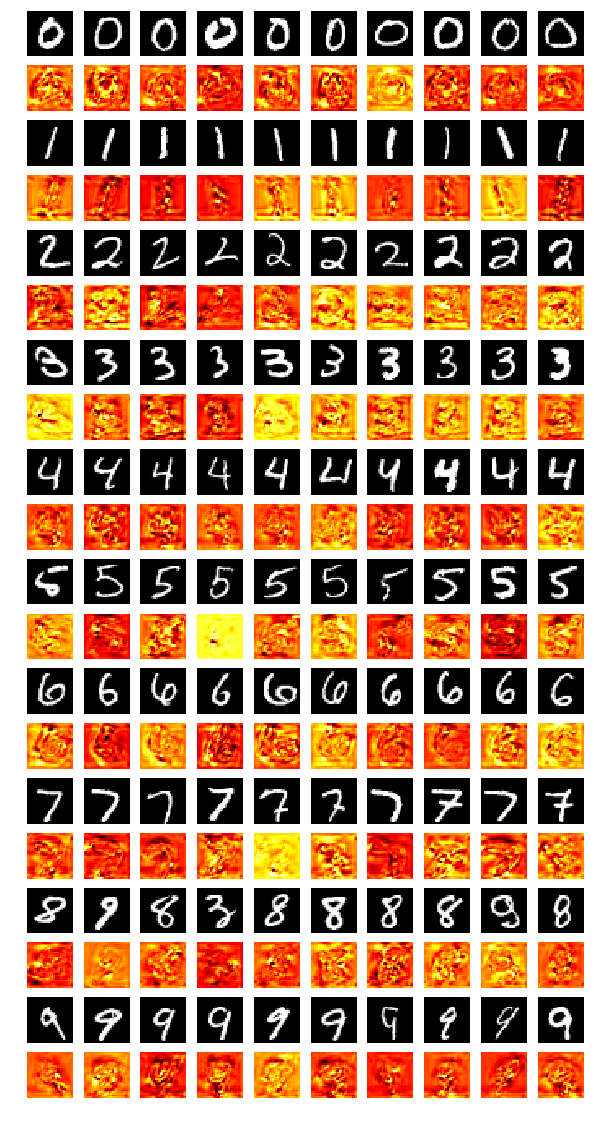

In [63]:
nb = 0
plt.figure(figsize=(10,int(10/nb_show*20)))
for x,s in zip(x_label, saliency_label):
    for x2 in x:
        nb += 1
        plt.subplot(20,nb_show,nb)
        plt.imshow(x2, 'gray')
        plt.axis('off')
        
    for s2 in s:
        nb += 1
        plt.subplot(20,nb_show,nb)
        plt.imshow(s2, 'hot')
        plt.axis('off')

# Grad-CAM
- [元論文 "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"](https://arxiv.org/abs/1610.02391)
- 第Lレイヤーで注視している領域を可視化する。
  1. 第Lレイヤーの出力をA<sup>L</sup>として、dy/dA<sup>L</sup>を計算する。A<sup>L</sup>の次元は縦x横xチャンネル。
  2. dy/dA<sup>L</sup>をチャンネル毎に平均する。これをα<sup>L</sup>とする。α<sup>L</sup>の次元はチャンネル次元のみ。
  3. A<sup>L</sup>の各チャンネルにα<sup>L</sup>を掛けて、チャンネル次元で和をとる。最後にReLUを掛ければGrad-CAMになる。

## dy/dAの計算

In [42]:
# Global Average Pooling(GAP)の1個手前のレイヤーのGrad-CAMを出力する。
# ここではGAPのレイヤー番号を取得する。
for i,layer in enumerate(cnn.layers):
    if layer.__class__.__name__=='GlobalAveragePooling2D':
        gap_idx = i

In [11]:
def compile_saliency_function_at_gap(model, gap_idx):
    '''
    GAPの入力
    = GAPの1つ前のレイヤーの出力
    = A
    として、dy/dAを計算する関数。
    '''
    inp = model.layers[0].input
    outp = model.layers[-1].output
    gap = model.layers[gap_idx].input
    saliency = K.gradients(K.max(outp,-1), gap)
    return K.function(inputs=[inp, K.learning_phase()], outputs=saliency)

In [49]:
# dy/dA^Lの計算
saliency_at_gap_fnc = compile_saliency_function_at_gap(cnn, gap_idx)
sal_test_gap = np.array(saliency_at_gap_fnc([x_test, 0]))[0]

## α<sup>L</sup>の計算

In [14]:
alpha_L = sal_test_gap.mean(1).mean(1)

## A<sup>L</sup>の計算

In [50]:
def func_get_activation(model, idx):
    inp = model.layers[0].input
    outp = model.layers[idx].output
    return K.function(inputs=[inp, K.learning_phase()], outputs=[outp])

In [51]:
get_activation = func_get_activation(cnn, gap_idx-1)
A_L = get_activation(([x_test, 0]))[0]

## Grad-CAMの計算

In [17]:
gradCAMs = []
for alpha, A in zip(alpha_L, A_L):
    foo = (A*alpha).sum(-1)
    gradCAMs.append(foo*(foo>0)) # ReLUを掛ける
gradCAMs = np.array(gradCAMs)

## Grad-CAMの描画

In [64]:
nb_show = 10

y_pred_label = cnn.predict(x_test).argmax(axis=1)

x_label = []
gradCAMs_label = []
for label in range(10):
    x_label.append(x_test[(y_pred_label==label)][:nb_show])
    gradCAMs_label.append(gradCAMs[(y_pred_label==label)][:nb_show])
x_label = np.array(x_for_each_pred_label).squeeze()
gradCAMs_label = np.array(gradCAMs_label).squeeze()

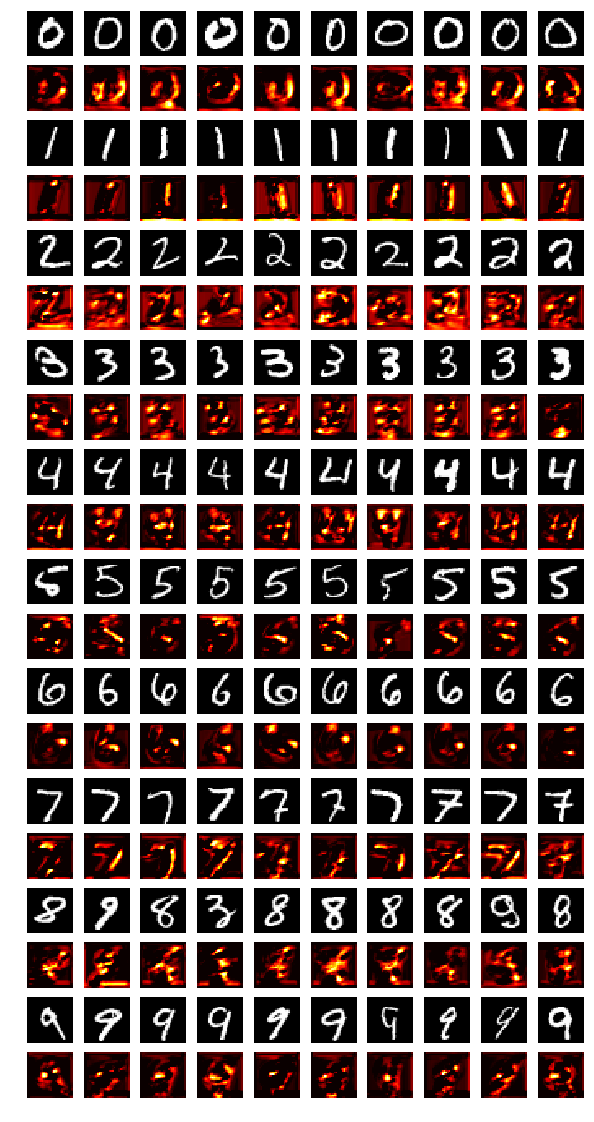

In [65]:
nb = 0
plt.figure(figsize=(10,int(10/nb_data_for_each_pred_label*20)))
for x,g in zip(x_label, gradCAMs_label):
    for x2 in x:
        nb += 1
        plt.subplot(20,nb_show,nb)
        plt.imshow(x2, 'gray')
        plt.axis('off')
        
    for g2 in g:
        nb += 1
        plt.subplot(20,nb_show,nb)
        plt.imshow(g2, 'hot')
        plt.axis('off')

# 注意
今回使ったCNNは、畳み込みフィルタサイズが(3,3)で、3回しか畳み込んでいない。なので、最大でも5ピクセル x 5ピクセルの大きさまでしか一度に見ることが出来ない。この大きさの事をreceptive fieldと言ったりする。receptive fieldより大きなサイズの特徴は学習することができない。なので、Grad-CAMによってそれっぽく可視化できたように見えるが、実際は局所特徴しか見えていない近視眼的なモデルとなっている。これを解決するには、  
1. プーリング層などを入れて粗視化する。
2. より大きなフィルタサイズを使用する。
3. より多く畳み込む（ディープにする）。  

といった方法が考えられる。最近の流行りは3.の方法で、例えばresidual connectionなどを使って数十層のCNN（ResNet）にしたりする。